In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"),
                   include=['application/javascript'])

def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [4]:
import sys, os
import glob
import warnings
sys.path.append('../')

from rankutils.utilities import merge_kfolds_rounds
from rankutils.rIO import read_rank
from rankutils.cfgloader import cfgloader
from rankutils.drawing import heatmap, annotate_heatmap, tableimg, annotate_tableimg
from rankutils.aggregation import *

import pandas
import imgkit

import numpy as np
from sklearn.preprocessing import minmax_scale, normalize
from sklearn.metrics import average_precision_score, precision_recall_curve

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange

from run_aggregation import *

In [5]:
def save_ascii_table(exname, method, tbl_names, tbl_scores, tbl_labels):    
    data = dict()
    data['Name'] = tbl_names
    
    for i in range(tbl_scores.shape[1]):
        data['Scores {0:d}'.format(i+1)] = tbl_scores[:, i]
        data['Labels {0:d}'.format(i+1)] = tbl_labels[:, i]
    
    
    save_tbl = pandas.DataFrame(data)
    
    outfname = "{0:s}_agg_tables.csv".format(exname.rsplit('.', 1)[0], method)
    save_tbl.to_csv(outfname)
    return

In [6]:
pathcfg = cfgloader("/home/alberto/phD/projects/performance_prediction/ret-mr-learning/source/path_2.cfg")
collection = 'places365'
keys=['places365_001', 'places365_002', 'places365_003', 'places365_004', 'places365_005']

#collection = 'imagenet'
#keys=['imagenet_001', 'imagenet_002', 'imagenet_003', 'imagenet_004']

#collection = 'vggfaces'
#keys=['vggfaces_001', 'vggfaces_003', 'vggfaces_004', 'vggfaces_005']

predmethod = '0009.irp.fusion-all.rbfsvm'
labeldir='/home/alberto/phD/projects/performance_prediction/ret-mr-learning/input-mod_labels/places365/pred0009/'
idx=12
topn=10
k=10
method = 'combSUM_pre'

In [7]:
names = []
scores = []
labels = []

for key in keys:
    ranktpname = pathcfg.get(key, 'rktpdir')

    rankfpaths = glob.glob(pathcfg.get(key, 'rank') + "*.rk")
    rankfpaths.sort()
    
    exname = os.path.basename(rankfpaths[idx])
    rank = read_rank(rankfpaths[idx], rows=topn)
    
    l = get_labels(glob.glob(labeldir + "/*{0:s}*".format(ranktpname))[0], k)
    
    names.append(rank['name'])
    scores.append(1 - normalize(rank['score'].reshape(1, -1)).reshape(-1))
    labels.append(l[idx, 0:k])
        
    tbl_names, tbl_scores, tbl_labels, tbl_stds = create_aggr_table(names, scores, labels, absent=np.NaN)
    
    kwargs = dict(names=tbl_names,
                  scores=tbl_scores,
                  labels=tbl_labels,
                  standings=tbl_stds,
                  f=1.00,
                  balance=0)
    
    aggr_names, aggr_scores = aggregate(method, **kwargs)
    
#save_ascii_table(exname, method, tbl_names, tbl_scores, tbl_labels)

In [8]:
def font_size_apply(val):
    return 'font-size: 8pt'

data = dict()

for i, _ in enumerate(keys):
    
    data['Names {0:03d}'.format(i)] = names[i]
    data['Scores {0:03d}'.format(i)] = scores[i].reshape(-1)
    data['Labels {0:03d}'.format(i)] = labels[i].reshape(-1)
    
df = pandas.DataFrame(data)
s = df.style.applymap(font_size_apply)
s

,Names 000,Scores 000,Labels 000,Names 001,Scores 001,Labels 001,Names 002,Scores 002,Labels 002,Names 003,Scores 003,Labels 003,Names 004,Scores 004,Labels 004
0,airplane_cabin_00000918.jpg,1,1,airplane_cabin_00000918.jpg,1,1,airplane_cabin_00000918.jpg,1,1,airplane_cabin_00000918.jpg,1,1,airplane_cabin_00000918.jpg,1,1
1,nursing_home_00002581.jpg,0.712917,0,airplane_cabin_00000357.jpg,0.72493,0,airplane_cabin_00003274.jpg,0.700709,0,airplane_cabin_00003274.jpg,0.71044,0,airplane_cabin_00000681.jpg,0.691789,0
2,airplane_cabin_00003677.jpg,0.705465,0,airplane_cabin_00001355.jpg,0.686767,0,nursing_home_00002581.jpg,0.69313,0,airplane_cabin_00003299.jpg,0.701963,0,clean_room_00002080.jpg,0.674811,0
3,airplane_cabin_00003274.jpg,0.671127,0,bus_interior_00000986.jpg,0.683632,0,airplane_cabin_00003677.jpg,0.684948,0,clean_room_00002080.jpg,0.666008,0,airplane_cabin_00003299.jpg,0.671615,0
4,clean_room_00002080.jpg,0.670237,0,airplane_cabin_00003677.jpg,0.666232,0,clean_room_00002080.jpg,0.679063,0,airplane_cabin_00003677.jpg,0.659424,0,airport_terminal_00001413.jpg,0.668302,0
5,airplane_cabin_00003299.jpg,0.66304,0,airplane_cabin_00002958.jpg,0.661922,0,airplane_cabin_00000994.jpg,0.667838,1,airplane_cabin_00003748.jpg,0.655823,0,nursing_home_00002581.jpg,0.663024,0
6,airplane_cabin_00002625.jpg,0.656932,0,airplane_cabin_00004366.jpg,0.654446,1,airplane_cabin_00003299.jpg,0.664708,0,airplane_cabin_00001767.jpg,0.655088,0,airplane_cabin_00000525.jpg,0.659337,0
7,airplane_cabin_00003649.jpg,0.650803,0,airplane_cabin_00001613.jpg,0.651505,0,airplane_cabin_00000681.jpg,0.647311,0,airplane_cabin_00002015.jpg,0.654811,0,airplane_cabin_00003535.jpg,0.658337,0
8,airplane_cabin_00000681.jpg,0.639686,0,airplane_cabin_00001880.jpg,0.643793,0,airplane_cabin_00003535.jpg,0.641224,0,hospital_room_00001726.jpg,0.652667,0,airplane_cabin_00000994.jpg,0.657506,0
9,airplane_cabin_00003535.jpg,0.63816,1,airplane_cabin_00000365.jpg,0.635726,0,airplane_cabin_00002625.jpg,0.628334,0,hospital_room_00000050.jpg,0.649901,0,dressing_room_00002453.jpg,0.656842,0


In [9]:
data = dict(Names=tbl_names)

def black_bg_apply(val):
    return 'background-color: black' if val == -1 else ''

for i in range(tbl_scores.shape[1]):
    
    data['Scores {0:03d}'.format(i)] = tbl_scores[:, i]
    
df = pandas.DataFrame(data)
df.style.applymap(font_size_apply).applymap(black_bg_apply)

,Names,Scores 000,Scores 001,Scores 002,Scores 003,Scores 004
0,airplane_cabin_00003299.jpg,0.66304,-1,0.664708,0.701963,0.671615
1,airplane_cabin_00000365.jpg,-1,0.635726,-1,-1,-1
2,airplane_cabin_00000918.jpg,1,1,1,1,1
3,airplane_cabin_00000681.jpg,0.639686,-1,0.647311,-1,0.691789
4,airplane_cabin_00000525.jpg,-1,-1,-1,-1,0.659337
5,airplane_cabin_00002625.jpg,0.656932,-1,0.628334,-1,-1
6,dressing_room_00002453.jpg,-1,-1,-1,-1,0.656842
7,airplane_cabin_00004366.jpg,-1,0.654446,-1,-1,-1
8,bus_interior_00000986.jpg,-1,0.683632,-1,-1,-1
9,hospital_room_00001726.jpg,-1,-1,-1,0.652667,-1


In [10]:
data = dict(Names=tbl_names)

def black_bg_apply(val):
    return 'background-color: black' if val == -1 else ''

for i in range(tbl_scores.shape[1]):
    
    data['Labels {0:03d}'.format(i)] = tbl_labels[:, i]
    
df = pandas.DataFrame(data)
df.style.applymap(font_size_apply)

,Names,Labels 000,Labels 001,Labels 002,Labels 003,Labels 004
0,airplane_cabin_00003299.jpg,-1,nan,-1,-1,-1
1,airplane_cabin_00000365.jpg,nan,-1,nan,nan,nan
2,airplane_cabin_00000918.jpg,1,1,1,1,1
3,airplane_cabin_00000681.jpg,-1,nan,-1,nan,-1
4,airplane_cabin_00000525.jpg,nan,nan,nan,nan,-1
5,airplane_cabin_00002625.jpg,-1,nan,-1,nan,nan
6,dressing_room_00002453.jpg,nan,nan,nan,nan,-1
7,airplane_cabin_00004366.jpg,nan,1,nan,nan,nan
8,bus_interior_00000986.jpg,nan,-1,nan,nan,nan
9,hospital_room_00001726.jpg,nan,nan,nan,-1,nan


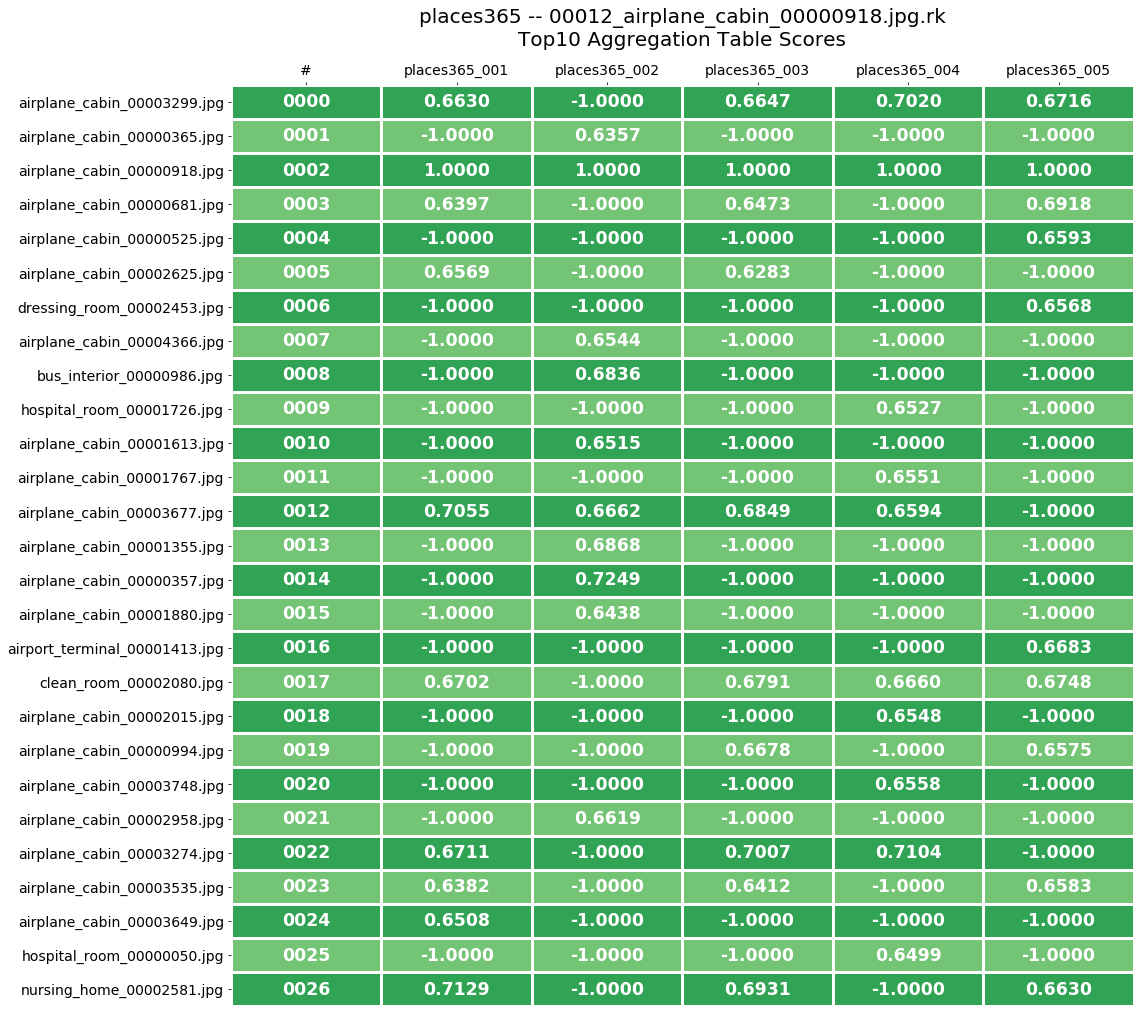

In [11]:
nsbpl = 1
fig, axes = plt.subplots(nsbpl)
fig.set_size_inches(16, nsbpl*16)
fig.tight_layout()

r = tbl_names.shape[0]

try:
    ax = axes[0]
except TypeError:
    ax = axes
im = tableimg((r, 1 + len(keys)), tbl_names, ['#'] + keys, ax=ax, 
             gridwidth=3.0, title="{0:s} -- {1:s}\nTop{2:d} Aggregation Table Scores".format(collection, exname, topn), 
             colorkw=dict(cmap='tab20c', cidx=[8, 9]), aspect='auto')

table = [np.arange(r, dtype=np.int32)] + [tbl_scores[:, i] for i in range(tbl_scores.shape[1])]

texts = annotate_tableimg(im, table, colfmt=["{x:04d}"] + ["{x:.4f}"]*5 + ["{x:d}"], 
                         **dict(fontsize='xx-large', color='white', weight='bold'))

#ax = axes[1]
#im = tableimg((r, 1 + len(keys)), tbl_names, ['#'] + keys, ax=ax, 
#              gridwidth=3.0, title="{0:s} -- {1:s}\nTop{2:d} Aggregation Table Labels".format(collection, exname, k), 
#              colorkw=dict(cmap='tab20c', cidx=[8, 9]), aspect='auto')

#table = [np.arange(r, dtype=np.int32)] + [tbl_labels[:, i] for i in range(tbl_labels.shape[1])]

#texts = annotate_tableimg(im, table, colfmt=["{x:04d}"] + ["{x:d}"]*5 + ["{x:d}"], 
#                          **dict(fontsize='xx-large', color='white', weight='bold'))

# ax = axes[0]
# im = tableimg((r, 1 + len(keys)), tbl_names, ['#'] + keys, ax=ax, 
#               gridwidth=3.0, title="{0:s} -- {1:s}\nTop{2:d} Aggregation Table Labels".format(collection, exname, k), 
#               colorkw=dict(cmap='tab20c', cidx=[8, 9]), aspect='auto')

# table = [np.arange(r, dtype=np.int32)] + [tbl_stds[:, i] for i in range(tbl_stds.shape[1])]

# texts = annotate_tableimg(im, table, colfmt=["{x:04d}"] + ["{x:d}"]*5 + ["{x:d}"], 
#                           **dict(fontsize='xx-large', color='white', weight='bold'))

plt.subplots_adjust(left=0.2, top=0.9, bottom=0.1, hspace=0.2)
#plt.savefig('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/misc./{0:s}_agg_tbl.svg'.format(exname))


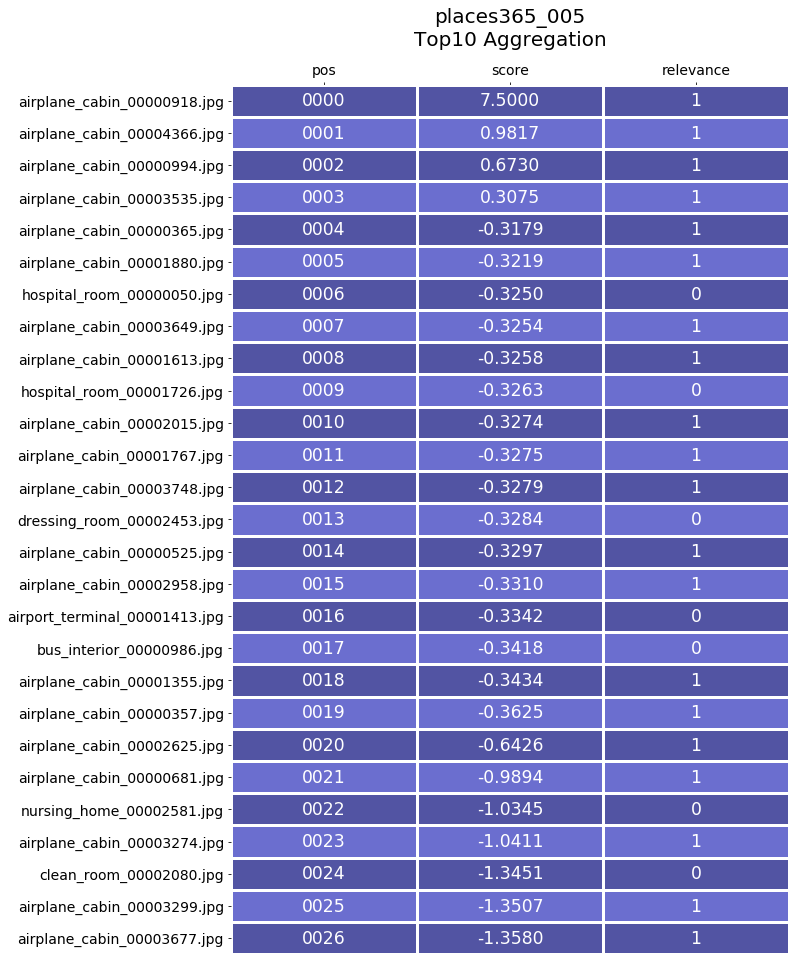

In [12]:
from run_aggregation import reevaluate, get_query_classname

fig, ax = plt.subplots(1)
fig.set_size_inches(10, 16)

aggr_rows = aggr_scores.shape[0]
aggr_eval = reevaluate(aggr_names, get_query_classname(exname), aggr_rows)

im = tableimg((aggr_rows, 3), aggr_names, ['pos', 'score', 'relevance'], ax=ax, 
              gridwidth=3.0, title="{0:s}\nTop{1:d} Aggregation".format(keys[i], topn, exname), 
              colorkw=dict(cmap='tab20b', cidx=[1, 2]), aspect='auto')

labels_aux = np.zeros(aggr_rows, dtype=np.int32)
labels_aux[0:aggr_rows] = aggr_eval
#np.place(labels_aux[0:aggr_rows], labels_aux[0:aggr_rows] == 0, -1)

tablearray = [np.arange(aggr_rows, dtype=np.int32), 
              aggr_scores.reshape(-1),
              labels_aux]

texts = annotate_tableimg(im, tablearray, colfmt=["{x:04d}", "{x:.4f}", "{x:d}"], 
                          **dict(fontsize='xx-large', color='white'))

outdata = pandas.DataFrame(dict(Names=aggr_names.reshape(-1), Scores=aggr_scores.reshape(-1), Eval=aggr_eval.reshape(-1)))
outdata.to_csv("{0:s}_{1:s}.csv".format(exname.rsplit('.', 1)[0], method))
